 # Comprehensive Website Crawling, Preservation & ChromaDB Indexing Notebook

 **Overview:**

 This notebook performs the following:

 1. **Data Collection:**
    - Crawls a website (using BFS restricted to one domain).
    - Saves each page’s raw HTML (after processing images, tables, and attachments), takes screenshots,
      converts pages to a “pretty” PDF, and downloads attachments (images, documents, tables).
    - Extracts screen reader–style text (alt texts, header information, ARIA labels).
    - Builds and exports both a BFS tree and a directed graph (with weighted edges) of the site’s interlinking.

 2. **ChromaDB Setup & Indexing:**
    - Extracts text from saved PDFs, text-PDFs, tables, and attachments (PDFs, DOCX, etc).
    - Uses a pretrained Hugging Face summarization model to extract key factual statements from the combined text.
    - Generates embeddings (with SentenceTransformers) and inserts documents (with metadata and facts) into a ChromaDB collection.

 3. **Embedding Creation & Benchmarking:**
    - Creates embeddings for all documents.
    - Benchmarks a keyword search (after stop-word filtering) to support a RAG pipeline.

 **Note:**
 - This notebook uses open-source libraries (Selenium, BeautifulSoup, pdfkit, PyPDF2, python‑docx, NetworkX, nltk, SentenceTransformers, chromadb, and Hugging Face Transformers).
 - Ensure wkhtmltopdf is installed on your system.


## Setup: Install & Import Required Libraries

 Install the following packages if not already installed:

 ```bash
 pip install selenium webdriver-manager beautifulsoup4 pdfkit networkx matplotlib PyPDF2 chromadb nltk sentence-transformers python-docx transformers
 ```

Also install wkhtmltopdf (see: https://wkhtmltopdf.org/downloads.html).


In [ ]:
# Install packages (uncomment if needed)
%pip install selenium webdriver-manager beautifulsoup4 pdfkit networkx matplotlib PyPDF2 chromadb nltk sentence-transformers python-docx transformers

# %% 
import os
import re
import time
import json
import requests
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# Selenium & webdriver-manager for dynamic pages
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# PDF conversion (requires wkhtmltopdf installed)
import pdfkit

# PDF text extraction
import PyPDF2

# For DOCX text extraction
import docx

# ChromaDB for document storage and retrieval
import chromadb
from chromadb.config import Settings

# NLTK for stop-word filtering
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# SentenceTransformers for embedding generation
from sentence_transformers import SentenceTransformer

# Hugging Face Transformers for fact extraction (summarization)
from transformers import pipeline

# Create directories for output if they don't exist
output_dirs = ["html", "screenshots", "pdfs", "text_pdfs", "images", "attachments", "tables", "embeddings"]
for folder in output_dirs:
    os.makedirs(folder, exist_ok=True)



 ## Utility Functions

 These functions help:
 - Create safe filenames from URLs.
 - Download files (images, documents).
 - Filter stopwords from text.
 - Extract a “screen reader” style summary from HTML.
 - Extract tables and process images/attachments.
 - Extract text from PDFs and DOCX attachments.


In [ ]:
def sanitize_filename(url: str) -> str:
    """Create a safe filename from a URL by removing non-alphanumeric characters."""
    return re.sub(r'[^a-zA-Z0-9]', '_', url)

def download_file(file_url: str, save_folder: str) -> str:
    """
    Download a file (image, document) from a URL to the specified folder.
    Returns the local file path.
    """
    try:
        response = requests.get(file_url, stream=True, timeout=10)
        if response.status_code == 200:
            filename = sanitize_filename(file_url)[:50]  # shorten filename if needed
            file_ext = os.path.splitext(file_url)[-1].split('?')[0] or ".bin"
            local_path = os.path.join(save_folder, f"{filename}{file_ext}")
            with open(local_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
            return local_path
    except Exception as e:
        print(f"Failed to download {file_url}: {e}")
    return ""

def filter_stopwords(text: str) -> str:
    """Remove common English stopwords from the text."""
    words = text.split()
    filtered = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered)

def extract_screen_reader_text(html: str) -> str:
    """
    Simulate a screen reader by extracting:
      - Alt text from images,
      - ARIA labels,
      - Header texts (h1-h6).
    Returns a concatenated textual summary.
    """
    soup = BeautifulSoup(html, "html.parser")
    texts = []
    # Extract alt text from images
    for img in soup.find_all("img"):
        alt = img.get("alt")
        if alt:
            texts.append(f"Image description: {alt}")
    # Extract ARIA labels
    for tag in soup.find_all(attrs={"aria-label": True}):
        texts.append(f"ARIA label: {tag.get('aria-label')}")
    # Extract header texts
    for i in range(1, 7):
        for header in soup.find_all(f"h{i}"):
            texts.append(f"Header: {header.get_text(strip=True)}")
    return "\n".join(texts)

def extract_tables(html: str, base_url: str) -> list:
    """
    Extract all tables from HTML.
    For each table, save its HTML to a file and also return its text content.
    """
    soup = BeautifulSoup(html, "html.parser")
    table_data = []
    tables = soup.find_all("table")
    for idx, table in enumerate(tables):
        table_html = str(table)
        filename = os.path.join("tables", f"{sanitize_filename(base_url)}_table_{idx}.html")
        with open(filename, "w", encoding="utf-8") as f:
            f.write(table_html)
        table_text = table.get_text(separator=" ", strip=True)
        table_data.append({"table_file": filename, "table_text": table_text})
    return table_data

def process_images(soup: BeautifulSoup, base_url: str) -> list:
    """
    Download all images referenced in the HTML.
    Update the <img> tag src attribute to point to the local file.
    Returns a list of downloaded image paths.
    """
    images_downloaded = []
    for img in soup.find_all("img", src=True):
        img_url = img["src"]
        # Convert relative URLs to absolute
        img_url = requests.compat.urljoin(base_url, img_url)
        local_path = download_file(img_url, "images")
        if local_path:
            images_downloaded.append(local_path)
            img["src"] = local_path  # update HTML to point to local image
    return images_downloaded

def process_attachments(soup: BeautifulSoup, base_url: str) -> list:
    """
    Download attachments (like PDFs, DOCX, etc.) linked in the page.
    Returns a list of dictionaries with original URL and local file path.
    """
    attachments = []
    # Look for anchor tags that link to common document types
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if any(href.lower().endswith(ext) for ext in [".pdf", ".doc", ".docx", ".xls", ".xlsx"]):
            att_url = requests.compat.urljoin(base_url, href)
            local_path = download_file(att_url, "attachments")
            if local_path:
                attachments.append({"original_url": att_url, "local_path": local_path})
                # Optionally, update the href in HTML to point to the local file
                a["href"] = local_path
    return attachments

def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extract text from a PDF using PyPDF2.
    Returns the extracted text.
    """
    text = ""
    if not pdf_path or not os.path.exists(pdf_path):
        return text
    try:
        with open(pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                extracted = page.extract_text()
                if extracted:
                    text += extracted + "\n"
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
    return text

def extract_text_from_docx(docx_path: str) -> str:
    """Extract text from a DOCX file using python-docx."""
    text = ""
    if not os.path.exists(docx_path):
        return text
    try:
        doc = docx.Document(docx_path)
        text = "\n".join([para.text for para in doc.paragraphs])
    except Exception as e:
        print(f"Error extracting text from {docx_path}: {e}")
    return text

def extract_text_from_attachment(file_path: str) -> str:
    """Determine attachment type by extension and extract text accordingly."""
    if not os.path.exists(file_path):
        return ""
    ext = os.path.splitext(file_path)[-1].lower()
    if ext == ".pdf":
        return extract_text_from_pdf(file_path)
    elif ext in [".docx"]:
        return extract_text_from_docx(file_path)
    # For .doc, .xls, etc., you might integrate textract or similar libraries
    else:
        return ""

def extract_text_and_headings(soup: BeautifulSoup) -> str:
    """
    Extract text from headings (h1-h6) and paragraphs.
    """
    text = ""
    for tag in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p']):
        if tag.name.startswith('h'):
            text += "\n" + tag.get_text(strip=True) + "\n"
        else:
            text += tag.get_text(strip=True) + " "
    return text

def create_text_pdf(text: str, output_path: str):
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    # Add a Unicode font. Ensure "DejaVuSans.ttf" is available in your working directory or adjust the path.
    pdf.add_font("DejaVu", "", "./DejaVuSans.ttf", uni=True)
    pdf.set_font("DejaVu", "", 12)
    for line in text.split('\n'):
        pdf.multi_cell(0, 10, line)
    pdf.output(output_path)


 ## Fact Extraction Function

 This function uses a Hugging Face summarization pipeline as a proxy to extract factual statements from text.
 (If you have local models you prefer – e.g. Qwen or DeepSeek – you can replace the pipeline initialization accordingly.)

In [ ]:
def extract_facts_from_text(text: str) -> str:
    """
    Given input text, break it into chunks (if too long) and generate summarized “facts” using a summarization model.
    """
    # Initialize summarization pipeline (you can replace the model with your local model if desired)
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn")
    chunk_size = 1024  # adjust based on model limits
    facts = []
    # Break text into chunks if necessary
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        # Some models expect a minimum length; catch errors if any
        try:
            summary = summarizer(chunk, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
            facts.append(summary)
        except Exception as e:
            print(f"Summarization error on chunk: {e}")
    return "\n".join(facts)

 ## Part 1: Data Collection – BFS Web Scraping & Preservation

 This function `crawl_site` performs a BFS crawl of the given homepage (restricted to a domain).
 For each page it:
 - Loads the page with Selenium (for dynamic content).
 - Processes images, attachments, and tables.
 - Saves the processed HTML, takes a screenshot, converts to PDF, and generates a text-PDF.
 - Extracts screen reader text.
 - Builds and updates a directed graph of interlinked pages.

In [ ]:
# Additional package installs for this cell (if needed)
# %pip install networkx fpdf

import networkx as nx
from fpdf import FPDF

def crawl_site(start_url: str, domain: str, max_pages: int = 50):
    queue = [start_url]
    visited = set()
    pages_data = {}
    graph = nx.DiGraph()

    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    # Set wkhtmltopdf path (adjust if necessary)
    path_wkhtmltopdf = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe'
    config = pdfkit.configuration(wkhtmltopdf=path_wkhtmltopdf)

    while queue and len(visited) < max_pages:
        url = queue.pop(0)
        if url in visited:
            continue

        try:
            print(f"Scraping: {url}")
            driver.get(url)
            time.sleep(2)
            html = driver.page_source

            soup = BeautifulSoup(html, "html.parser")
            
            # Process images, attachments, and tables
            images = process_images(soup, url)
            attachments = process_attachments(soup, url)
            tables = extract_tables(html, url)
            screen_reader_text = extract_screen_reader_text(html)
            
            processed_html = str(soup)
            html_filename = os.path.join("html", f"{sanitize_filename(url)}.html")
            with open(html_filename, "w", encoding="utf-8") as f:
                f.write(processed_html)
            
            screenshot_filename = os.path.join("screenshots", f"{sanitize_filename(url)}.png")
            driver.save_screenshot(screenshot_filename)
            
            pdf_filename = os.path.join("pdfs", f"{sanitize_filename(url)}.pdf")
            try:
                pdfkit.from_url(url, pdf_filename, configuration=config)
            except Exception as pdf_err:
                print(f"PDF conversion failed for {url}: {pdf_err}")
                pdf_filename = None

            text_content = extract_text_and_headings(soup)
            text_pdf_filename = os.path.join("text_pdfs", f"{sanitize_filename(url)}_text.pdf")
            create_text_pdf(text_content, text_pdf_filename)

            # Collect outlinks and update graph structure
            links = []
            for a in soup.find_all("a", href=True):
                link = a["href"]
                link = requests.compat.urljoin(url, link)
                if domain in link:
                    links.append(link)
                    if graph.has_edge(url, link):
                        graph[url][link]['weight'] += 1
                    else:
                        graph.add_edge(url, link, weight=1)
                    if link not in visited and link not in queue:
                        queue.append(link)

            pages_data[url] = {
                "html_path": html_filename,
                "screenshot_path": screenshot_filename,
                "pdf_path": pdf_filename,
                "text_pdf_path": text_pdf_filename,
                "images": images,
                "attachments": attachments,
                "tables": tables,
                "screen_reader_text": screen_reader_text,
                "links": links,
                "raw_html": html,  # original HTML for further processing if needed
            }
            visited.add(url)
        except Exception as e:
            print(f"Error scraping {url}: {e}")
            visited.add(url)
    driver.quit()
    return pages_data, graph


### Run the Crawler

 Provide the homepage URL and the domain to restrict the crawl. Adjust `max_pages` as needed.

In [ ]:
start_url = "https://iiitd.ac.in/"  # Replace with your homepage URL
domain = "iiitd.ac.in"             # Replace with your target domain
pages_data, link_graph = crawl_site(start_url, domain, max_pages=20)

 ### Visualize and Export the Graph Structure

 This code visualizes the interlinking graph and saves the graph structure as JSON.

In [ ]:
def visualize_graph(graph: nx.DiGraph):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph, k=0.5, iterations=20)
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8, arrowsize=10)
    plt.title("Graph of Interlinked Pages")
    plt.show()

visualize_graph(link_graph)

# Save the graph as JSON (nodes and edges)
graph_data = {
    "nodes": list(link_graph.nodes()),
    "edges": [{"source": u, "target": v, "weight": d["weight"]} for u, v, d in link_graph.edges(data=True)]
}
with open("graph_structure.json", "w", encoding="utf-8") as f:
    json.dump(graph_data, f, indent=2)


 ## Part 2: Data Extraction, Fact Generation & ChromaDB Indexing

 For each crawled page, we now extract text from:
 - The PDF generated from the page.
 - The text-PDF (headings/paragraphs) and screen reader text.
 - All tables (their text).
 - All attachments (PDFs, DOCX, etc).

 We combine these sources, run fact extraction (via a summarization model), and then index the resulting document into ChromaDB.

 The document text for indexing is set to the extracted facts (if available) so that the search is aligned with the RAG pipeline.


In [ ]:
def extract_text_from_attachment_files(attachments: list) -> str:
    """Iterate through attachments and extract text from supported file types."""
    all_text = ""
    for att in attachments:
        local_path = att.get("local_path", "")
        if local_path:
            text = extract_text_from_attachment(local_path)
            if text:
                all_text += text + "\n"
    return all_text

# Prepare a list to hold factual data for later export
factual_data = []

# Initialize a ChromaDB collection for the website documents
os.environ["CHROMA_DB_PATH"] = "./chroma_db"
client = chromadb.Client()
collection = client.create_collection(name="website_docs", get_or_create=True)

# Loop over pages and extract text from PDFs, attachments, tables, etc.
for url, data in pages_data.items():
    # Extract text from the page PDF
    pdf_path = data.get("pdf_path")
    pdf_text = extract_text_from_pdf(pdf_path)
    
    # If PDF extraction failed, fallback to screen reader text and raw HTML text extraction
    if not pdf_text.strip():
        pdf_text = data.get("screen_reader_text", "") + "\n" + extract_text_and_headings(BeautifulSoup(data.get("raw_html", ""), "html.parser"))
    
    # Extract table texts (if any)
    tables = data.get("tables") or []
    tables_text = " ".join([t["table_text"] for t in tables])
    
    # Extract text from attachments (e.g. PDFs, DOCX)
    attachments = data.get("attachments") or []
    attachments_text = extract_text_from_attachment_files(attachments)
    
    # Combine all extracted texts
    combined_text = "\n".join([pdf_text, tables_text, attachments_text])
    
    # Generate facts using the summarization/fact extraction model
    facts = extract_facts_from_text(combined_text) if combined_text.strip() else ""
    
    # For indexing, use the extracted facts if available, otherwise fallback to combined_text
    doc_text = facts if facts.strip() else combined_text

    # Append facts to the separate factual data list (for export)
    factual_data.append({"url": url, "facts": facts})
    
    # Prepare metadata (store extra info if desired)
    metadata = {
        "url": url,
        "html_path": data.get("html_path") or "",
        "screenshot": data.get("screenshot_path") or "",
        "images": json.dumps(data.get("images") or []),
        "attachments": json.dumps(data.get("attachments") or []),
        "screen_reader_text": data.get("screen_reader_text") or "",
        "tables": json.dumps(tables),
        "pdf_path": pdf_path or "",
        "text_pdf_path": data.get("text_pdf_path") or ""
    }

    # Add document (with facts as text) into ChromaDB
    collection.add(
        documents=[doc_text],
        metadatas=[metadata],
        ids=[sanitize_filename(url)]
    )
    print(f"Added document for {url} to ChromaDB.")

# Save the factual data to a JSON file for reference
with open("factual_data.json", "w", encoding="utf-8") as f:
    json.dump(factual_data, f, indent=2)
print("Factual data saved to factual_data.json")


 ## Part 3: Embedding Creation & Benchmarking Keyword Search

 This section creates embeddings for each document (using SentenceTransformers) and optionally updates
 ChromaDB with these vectors. It then benchmarks a sample query (with stop-word filtering) to ensure the search
 is in sync with the fact–based documents, supporting our RAG pipeline.

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\amart\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Scraping: https://iiitd.ac.in/
Scraping: https://iiitd.ac.in/#main-content
Scraping: https://iiitd.ac.in/#skipcont
Scraping: https://iiitd.ac.in/screenreader
Scraping: https://iiitd.ac.in/sdg/
Scraping: https://iiitd.ac.in/directory
Scraping: https://iiitd.ac.in/tenders
Failed to download http://www.iiitd.ac.inhttps://www.iiitd.ac.in/sites/default/files/docs/tenders/Tender-Mess2014.pdf: HTTPConnectionPool(host='www.iiitd.ac.inhttps', port=80): Max retries exceeded with url: /www.iiitd.ac.in/sites/default/files/docs/tenders/Tender-Mess2014.pdf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x000001D392F4B3A0>: Failed to resolve 'www.iiitd.ac.inhttps' ([Errno 11001] getaddrinfo failed)"))
Scraping: https://iiitd.ac.in/rti
Scraping: https://giving.iiitd.ac.in
Error scraping https://giving.iiitd.ac.in: Message: unknown error: net::ERR_CONNECTION_TIMED_OUT
  (Session info: chrome=134.0.6998.89)
Stacktrace:
	GetHandleVerifier [0x00B2B593+24387]
	(No symbol) [0x0

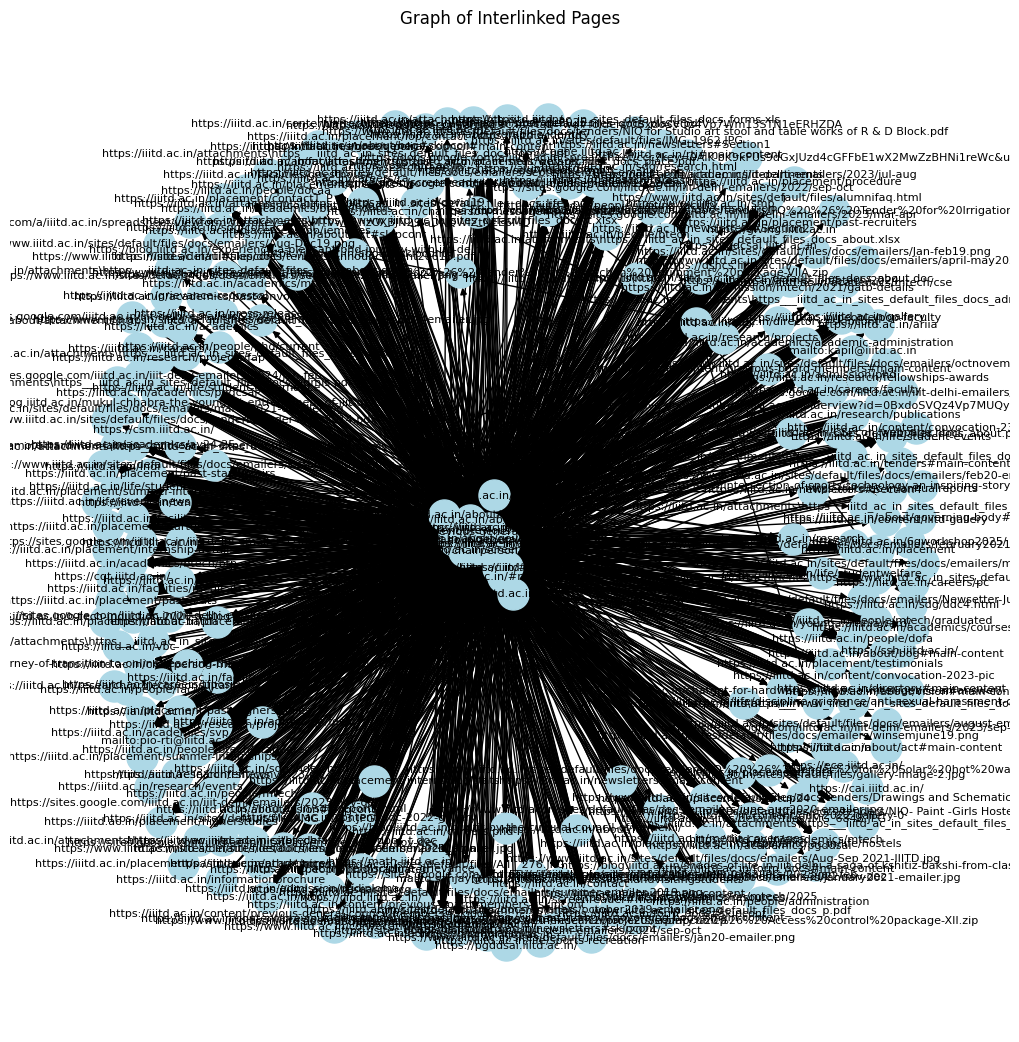

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Added document for https://iiitd.ac.in/ to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/#main-content to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/#skipcont to ChromaDB.


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Added document for https://iiitd.ac.in/screenreader to ChromaDB.


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Added document for https://iiitd.ac.in/sdg/ to ChromaDB.


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Added document for https://iiitd.ac.in/directory to ChromaDB.


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Added document for https://iiitd.ac.in/tenders to ChromaDB.


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Added document for https://iiitd.ac.in/rti to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/form_docs to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/about to ChromaDB.


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Added document for https://iiitd.ac.in/about/vision to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/chairperson-message to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/about/act to ChromaDB.


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Added document for https://iiitd.ac.in/newsletters to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/about/governing-body to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/about/general-council to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/about/bog to ChromaDB.


Device set to use cuda:0


Added document for https://iiitd.ac.in/content/previous-general-council-members to ChromaDB.


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Added document for https://iiitd.ac.in/content/previous-board-members to ChromaDB.
Factual data saved to factual_data.json


Device set to use cuda:0


Created embedding for https://iiitd.ac.in/


Device set to use cuda:0


Created embedding for https://iiitd.ac.in/#main-content


Device set to use cuda:0


Created embedding for https://iiitd.ac.in/#skipcont


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Created embedding for https://iiitd.ac.in/screenreader


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Created embedding for https://iiitd.ac.in/sdg/


Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Created embedding for https://iiitd.ac.in/directory


Device set to use cuda:0


In [ ]:
# Load a pre-trained SentenceTransformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def create_embedding(text: str):
    return embedding_model.encode(text).tolist()

# Create embeddings for each document and store them locally (or update ChromaDB as needed)
for url, data in pages_data.items():
    # Use the same extraction logic as before
    pdf_text = extract_text_from_pdf(data.get("pdf_path", ""))
    if not pdf_text.strip():
        pdf_text = data.get("screen_reader_text", "")
    tables = data.get("tables") or []
    tables_text = " ".join([t["table_text"] for t in tables])
    attachments_text = extract_text_from_attachment_files(data.get("attachments") or [])
    combined_text = "\n".join([pdf_text, tables_text, attachments_text])
    facts = extract_facts_from_text(combined_text) if combined_text.strip() else ""
    doc_text = facts if facts.strip() else combined_text
    if doc_text.strip():
        emb = create_embedding(doc_text)
        embedding_filename = os.path.join("embeddings", f"{sanitize_filename(url)}.json")
        with open(embedding_filename, "w", encoding="utf-8") as f:
            json.dump(emb, f)
        print(f"Created embedding for {url}")

# %%
def benchmark_search(query: str, n_results: int = 5):
    """
    Benchmark a sample search query.
    It first filters the query to remove stopwords, then performs a search on the ChromaDB collection.
    """
    start_time = time.time()
    filtered_query = filter_stopwords(query)
    results = collection.query(query_texts=[filtered_query], n_results=n_results)
    elapsed = time.time() - start_time
    print(f"Search for '{query}' (filtered: '{filtered_query}') took {elapsed:.2f} seconds")
    return results

# Run an example search query
benchmark_results = benchmark_search("Ranjan Bose")
print("Benchmark results:", benchmark_results)
